In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Acoustic Ray Tracing in the SOFAR Channel

##  Ray Tracing in the SOFAR Channel

This section investigates the behavior of sound waves as they propagate through a simplified ocean environment, focusing on the SOFAR channel's unique sound speed profile.

* **1.1 Environment Parameters:** Definition of key physical parameters, including minimum and maximum sound speeds, and ocean depths.
* **1.2 Speed Sound Profile:** Calculation and visualization of the sound speed as a function of depth, highlighting the SOFAR channel.
* **1.3 Simulation Parameters:** Setup of parameters for the ray tracing simulation, such as source location and transmission angles.
* **1.4 Ray Tracing:** Implementation of the ray tracing to model sound wave paths through the sound speed profile.


In [117]:
#make the environment parameters al
#speed of sound min & max 
MIN_SOUND_SPEED = 1480
MAX_SOUND_SPEED = 1530

#depth numbers --> where they'll be on the grid
#in meters
MIN_DEPTH = 0
MAX_DEPTH = 5500

#the depth we experience the min sound speed
MIN_SPEED_DEPTH = 1100

#pick depth points to make it easier to plot and calculate stuff
DEPTHS = np.arange(MIN_DEPTH, MAX_DEPTH + 1)

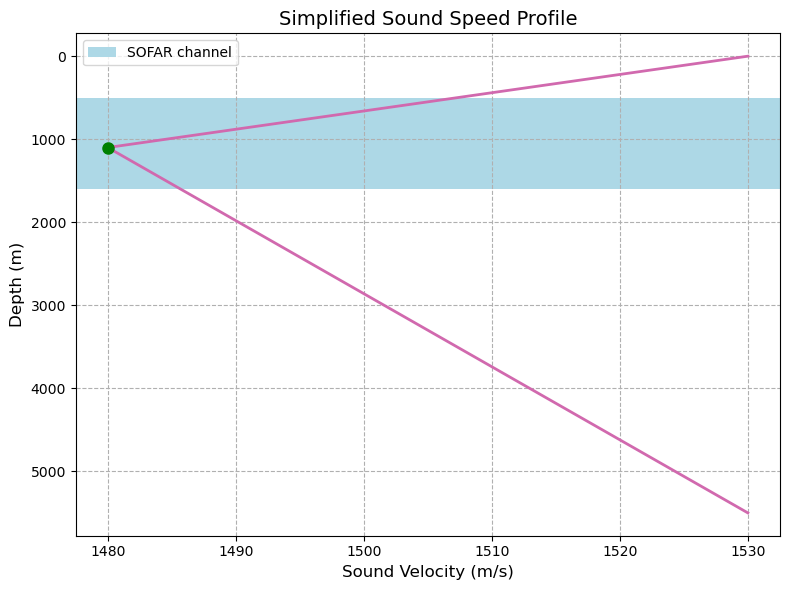

In [118]:
#speed sound profile
#split the plot into shallow and deep levels
#basically above the sofar channel and below
#the change in sound speed over  the change in depth


#above the sofar channel
ABOVE_SOFAR = (MIN_SOUND_SPEED-MAX_SOUND_SPEED)/(MIN_SPEED_DEPTH-MIN_DEPTH)

#below the sofar channel
BELOW_SOFAR = (MAX_SOUND_SPEED-MIN_SOUND_SPEED)/(MAX_DEPTH-MIN_SPEED_DEPTH)


#check that each point in the depths array is within the "shallow" portion (above the sofar channel)
#fill a vector with a 1 if its true
shallowGrad  = np.full((1, np.argwhere(DEPTHS == MIN_SPEED_DEPTH)[0][0]), ABOVE_SOFAR)

deepGrad = np.full((1, np.argmax(DEPTHS) - np.argwhere(DEPTHS == MIN_SPEED_DEPTH)[0][0]), BELOW_SOFAR)


soundVelocityProfile = MIN_SOUND_SPEED + (DEPTHS[:-1] - MIN_SPEED_DEPTH) * np.append(shallowGrad, deepGrad)

# plot the sound velocity profile with visual aids
fig = plt.figure(figsize=(8,6))
plt.plot(soundVelocityProfile, DEPTHS[:-1], color="#d169ae", linewidth=2)
plt.plot([MIN_SOUND_SPEED], [MIN_SPEED_DEPTH], 'go', markersize=8)
plt.axhspan(500, 1600, facecolor='lightblue', alpha=1, label='SOFAR channel')
plt.title("Simplified Sound Speed Profile", fontsize=14)
plt.ylabel('Depth (m)', fontsize=12)
plt.xlabel('Sound Velocity (m/s)', fontsize=12)
plt.tick_params(axis='both')
ax = plt.gca()
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.legend()
plt.show()

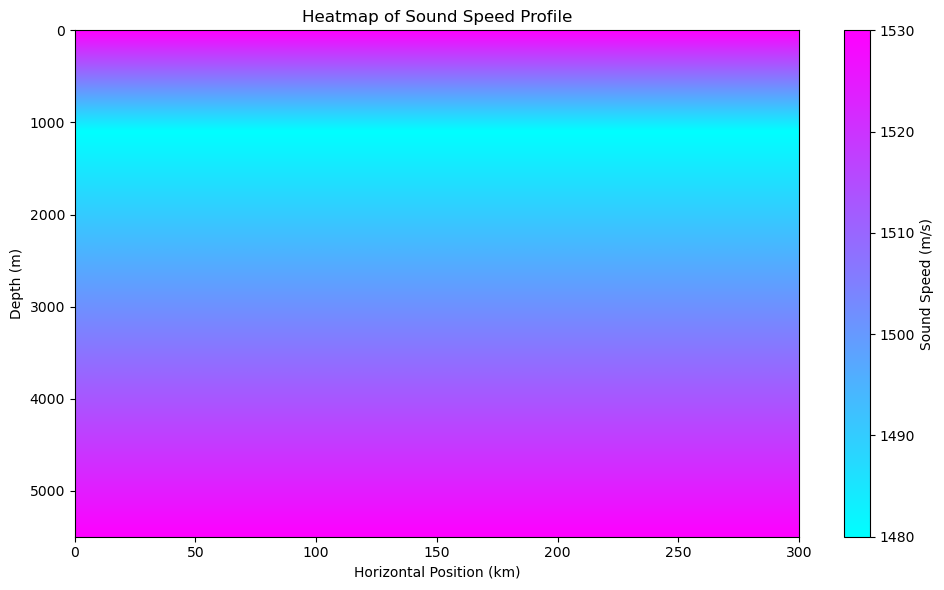

In [119]:
#do the same for the horizontal axis
#do a heat map using the above plot to 
horizontalRes = 300 #how many columns we use
soundMap = np.tile(soundVelocityProfile[:, np.newaxis], (1, horizontalRes))


#plot the heat map
plt.figure(figsize=(10, 6))
extent = [0, horizontalRes, DEPTHS[0], DEPTHS[-2]]  # match depth range
plt.imshow(
    soundMap,
    extent=extent,
    aspect='auto',
    origin='lower',
    cmap='cool'
)

plt.colorbar(label='Sound Speed (m/s)')
plt.xlabel("Horizontal Position (km)")
plt.ylabel("Depth (m)")
plt.gca().invert_yaxis()
plt.title("Heatmap of Sound Speed Profile")
plt.tight_layout()
plt.show()


In [120]:
#set up the source for the sound wave
#need the transmission angle and 

#the source of the sound has to happen where the sofar channel is (lowest sound speed)
SOURCEDEPTH = MIN_SPEED_DEPTH
SOURCESOUNDSPEED = MIN_SOUND_SPEED

#transmission angle in radians
TRANSMISSION_ANGLE = np.deg2rad(np.arange(-10, 15, 1))

#save the 0th angle, where the wave starts
angle0 = np.argwhere(TRANSMISSION_ANGLE == 0)[0][0]

#the distance we're going to observe meters
SIMSTEPS = 20

#get even bins for the range, in centimeters
SIMRANGE =  np.arange(0, 200e3 + SIMSTEPS, SIMSTEPS)


#make the matrices
R = np.zeros((len(TRANSMISSION_ANGLE), len(SIMRANGE))) #the horizontal range of each ray at each step
z = np.zeros_like(R) #the depth of each ray at each step
c = np.zeros_like(R) #the sound speed at each ray's position at each step
theta = np.zeros_like(R) #the angle of each ray's path at each step

#initial conditions
z[:, 0] = MIN_SPEED_DEPTH  # we put the source at the depth of min sound speed
R[:, 0] = -SOURCESOUNDSPEED / np.append(
    ABOVE_SOFAR * np.cos(TRANSMISSION_ANGLE[:angle0+1]),
    BELOW_SOFAR * np.cos(TRANSMISSION_ANGLE[angle0+1:]),
)
c[:, 0] = MIN_SOUND_SPEED
theta[:, 0] = TRANSMISSION_ANGLE

In [121]:
#calculate how sound waves travel the distance
#iterate through the sim steps and each sound rays
for j in range(1, len(SIMRANGE)):
    for i in range(len(TRANSMISSION_ANGLE)):
        
        #if we're at the sofar channel and the wave isn't going anywhere
        #make everything the default
        if (z[i, j-1] == SOURCEDEPTH) and (theta[i, j-1] == 0):
            c[i, j] = SOURCESOUNDSPEED
            theta[i, j] = 0
            dz = 0
            z[i, j] = SOURCEDEPTH

        #if the ray is at the sofar channel depth or above it & the ray is traveling downwards
        elif ((z[i, j-1] < SOURCEDEPTH) or (z[i, j-1] == SOURCEDEPTH and theta[i, j-1] > 0)):
            #update the horizontal range to store the equation
            #-sound of speed / shallow gradient * cos(theta)
            R[i, j] = -c[i, j-1] / (ABOVE_SOFAR * np.cos(theta[i, j-1]))

            #update the angle at this step
            theta[i, j] = np.arcsin( SIMSTEPS / R[i, j-1] + np.sin(theta[i, j-1]))

            #the change of depth
            dz = R[i, j-1] * (np.cos(theta[i, j-1]) - np.cos(theta[i, j]))

            #set the depth and sound speed to what the calculations say
            z[i, j] = z[i, j-1] + dz
            c[i, j] = SOURCESOUNDSPEED + ABOVE_SOFAR * (z[i, j] - SOURCEDEPTH)

        #at the sofar channel or BELOW and travelling upwards
        elif ((z[i, j-1] > SOURCEDEPTH) or (z[i, j-1] == SOURCEDEPTH and theta[i, j-1] < 0)):

            #update the horizontal range
            R[i, j] = -c[i, j-1] / (BELOW_SOFAR * np.cos(theta[i, j-1]))
            theta[i, j] = np.arcsin(SIMSTEPS / R[i, j-1] + np.sin(theta[i, j-1]))

            #the change in depth
            dz = R[i, j-1] * (np.cos(theta[i, j-1]) - np.cos(theta[i, j]))

            #new depth and sound speed
            z[i, j] = z[i, j-1] + dz
            c[i, j] = SOURCESOUNDSPEED + BELOW_SOFAR * (z[i, j] - SOURCEDEPTH)


In [122]:
#repeat the same profile to create a 2d map
num_horizontal_points = len(SIMRANGE) 

#make this the sound map that will hold the ray tracing
sound_map = np.tile(soundVelocityProfile[:, np.newaxis], (1, num_horizontal_points))


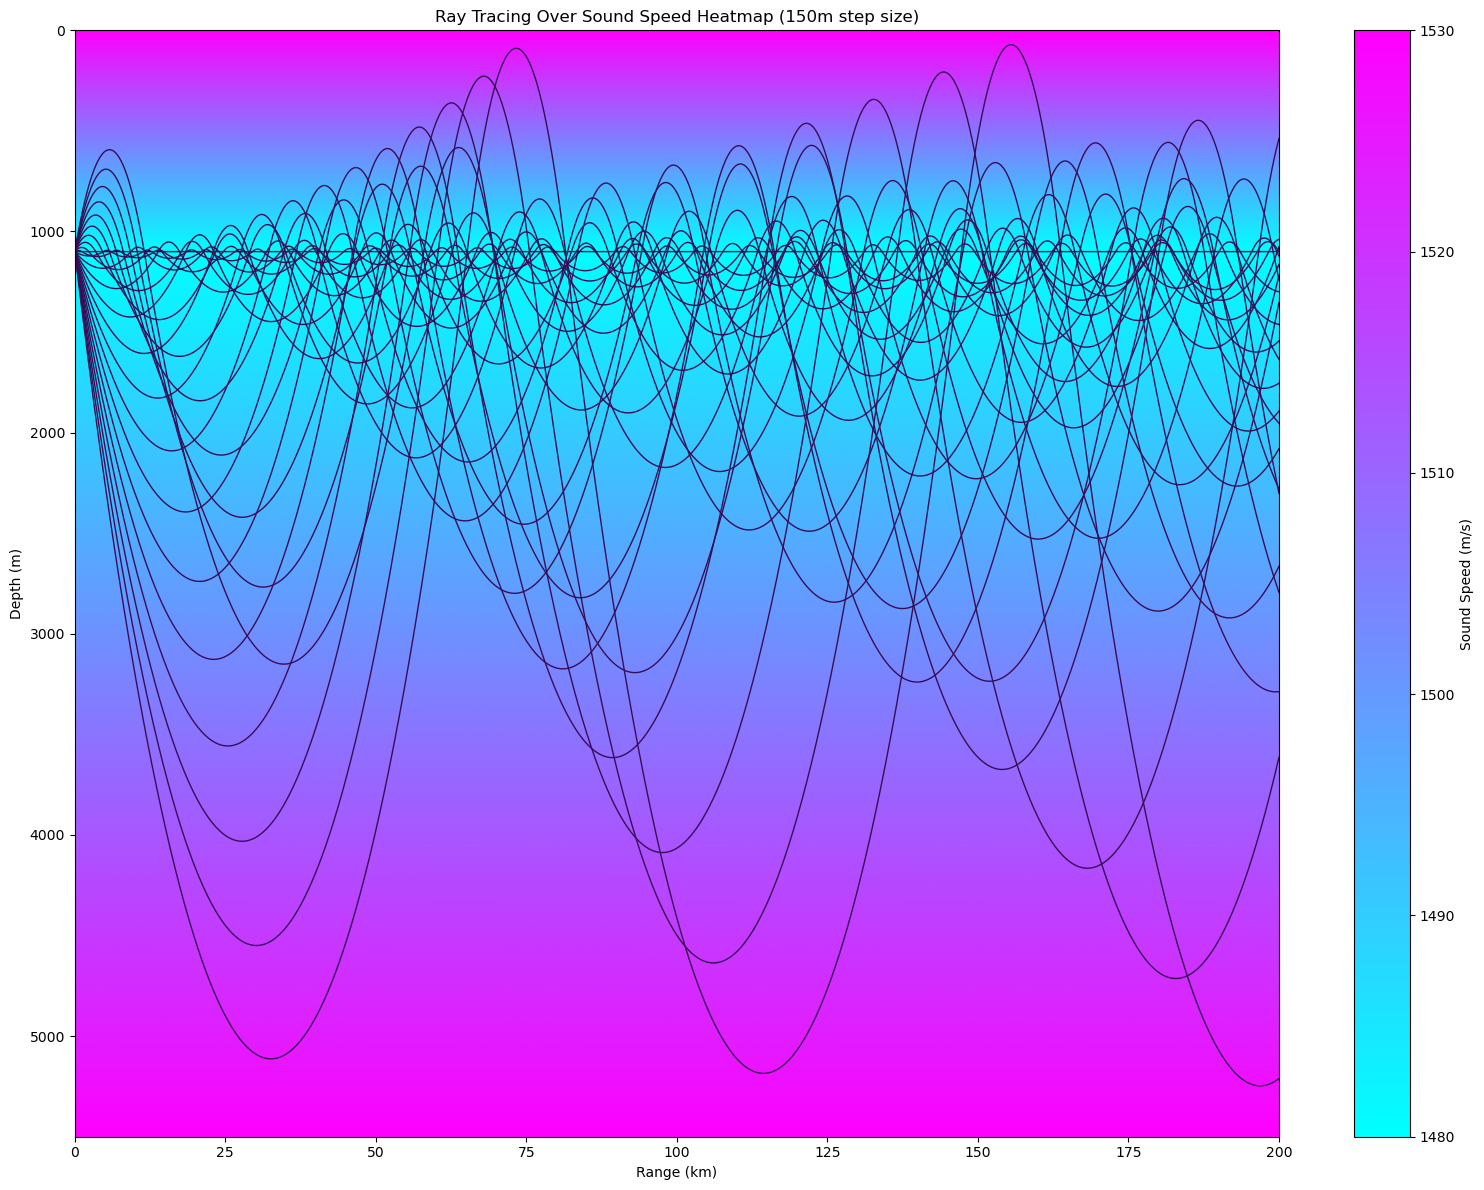

In [ ]:
fig, ax = plt.subplots(figsize=(16, 12))

#Plot the background heatmap
extent = [SIMRANGE[0]/1000, SIMRANGE[-1]/1000, DEPTHS[0], DEPTHS[-2]]
im = ax.imshow(
    sound_map,
    extent=extent,
    origin='lower',
    aspect='auto',
    cmap='cool',
    alpha=1
)

# Overlay the ray paths
for i in range(z.shape[0]):
    ax.plot(SIMRANGE / 1000, z[i], color='#380d57', linewidth=1)

# Labels and colorbar
plt.colorbar(im, label='Sound Speed (m/s)')
ax.set_xlabel("Range (km)")
ax.set_ylabel("Depth (m)")
ax.set_ylim(0, 5500)
ax.invert_yaxis()
ax.set_title("Ray Tracing Over Sound Speed Heatmap")
plt.tight_layout()
plt.show()